In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import torch
import random
import math
import copy
import os
import sys
from itertools import permutations
from itertools import product
from typing import Callable, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd

In [2]:
from typing import List, Optional, Tuple

import torch
import torch.nn as nn
from torch_geometric.data import Data


class TemporalData(Data):

    def __init__(self,
                 x: Optional[torch.Tensor] = None,
                 positions: Optional[torch.Tensor] = None,
                 edge_index: Optional[torch.Tensor] = None,
                 edge_attrs: Optional[List[torch.Tensor]] = None,
                 y: Optional[torch.Tensor] = None,
                 file_name: Optional[str] = None,
                 num_nodes: Optional[int] = None,
                 padding_mask: Optional[torch.Tensor] = None,
                 bos_mask: Optional[torch.Tensor] = None,
                 rotate_angles: Optional[torch.Tensor] = None,
                 lane_vectors: Optional[torch.Tensor] = None,
                 lane_ctrs: Optional[torch.Tensor] = None,
                 lane_idcs: Optional[torch.Tensor] = None,
                 theta: Optional[torch.Tensor] = None,
                 rotate_mat: Optional[torch.Tensor] = None,
                #  cav_idx: Optional[np.array] = None,
                #  ncv_idx: Optional[np.array] = None,
                #  cv_idx: Optional[np.array] = None,
                obj_type_02: Optional[list] = None,
                obj_type_04: Optional[list] = None,
                obj_type_06: Optional[list] = None,
                obj_type_08: Optional[list] = None,
                in_av_range: Optional[list] = None,
                 **kwargs) -> None:
        if x is None:
            super(TemporalData, self).__init__()
            return
        super(TemporalData, self).__init__(x=x, positions=positions, y=y, file_name=file_name, num_nodes=num_nodes,
                                           padding_mask=padding_mask, bos_mask=bos_mask, rotate_angles=rotate_angles,
                                           lane_vectors=lane_vectors, lane_ctrs=lane_ctrs, lane_idcs = lane_idcs, 
                                           theta=theta, rotate_mat=rotate_mat, obj_type_02=obj_type_02, 
                                           obj_type_04=obj_type_04, obj_type_06=obj_type_06, obj_type_08=obj_type_08, 
                                           in_av_range=in_av_range, **kwargs)
        if edge_attrs is not None:
            for t in range(self.x.size(1)):
                self[f'edge_attr_{t}'] = edge_attrs[t]

    def __inc__(self, key, value):
        if key == 'lane_actor_index':
            return torch.tensor([[self['lane_vectors'].size(0)], [self.num_nodes]])
        else:
            return super().__inc__(key, value)

/opt/anaconda3/envs/carla_data/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
frame = 31851
cav = 571
raw_path = "../../scene_mining/scene_{}_{}".format(frame,cav)
df = pd.read_csv(raw_path)

In [251]:
df.head()


,frame,time,vid,type_id,position_x,position_y,position_z,rotation_x,rotation_y,rotation_z,vel_x,vel_y,angular_z,obj_type_mpr_02,obj_type_mpr_04,obj_type_mpr_06,obj_type_mpr_08,in_av_range
0,31801,0:00:10:0810,401,vehicle.tesla.model3,236.415131,53.560398,0.001483,-0.000031,-0.001953,90.693298,3.457908e-08,2.307362e-09,-2.936744e-09,ncv,ncv,ncv,cv,False
1,31801,0:00:10:0810,409,vehicle.gazelle.omafiets,237.606689,106.041481,-0.013334,0.004829,0.218996,91.331276,-9.578159e-02,4.080796e+00,7.327369e-02,ncv,ncv,ncv,ncv,True
2,31801,0:00:10:0810,412,vehicle.bmw.isetta,246.875626,51.436581,0.001251,0.000431,0.031426,-88.655052,1.034221e-01,-4.410285e+00,1.829045e-03,ncv,ncv,ncv,cv,False
3,31801,0:00:10:0810,454,vehicle.citroen.c3,234.176544,116.039940,0.038404,0.003857,-0.000642,91.738113,-1.296484e-01,4.975683e+00,-6.473547e-01,ncv,ncv,ncv,ncv,True
4,31801,0:00:10:0810,456,vehicle.diamondback.century,234.058121,105.858330,-0.017584,-0.000092,-0.303247,91.388824,-1.008894e-01,4.164351e+00,-1.357185e-02,ncv,ncv,ncv,ncv,True


In [2]:
cv_range = 50
sys.path.append('/Users/xichen/Documents/paper2-traj-pred/carla-data/maps/lanelet2')
sys.path.append('/Users/xichen/Documents/paper2-traj-pred/carla-data')
import lane_segment, load_xml
from utils.lane_sampling import Spline2D, visualize_centerline

obs_len = 50
obs_range = 50 #traj length
fut_len = 50
normalized = True
split = "train"
def get_lane_feats(origin, rotate_mat, radius=75):
    roads = load_xml.load_lane_segments_from_xml("../../maps/lanelet2/Town03.osm")
    polygon_bboxes, lane_starts, lane_ends = load_xml.build_polygon_bboxes(roads)
    road_ids = load_xml.get_road_ids_in_xy_bbox(polygon_bboxes, lane_starts, lane_ends, roads, origin[0], origin[1], radius)
    road_ids = copy.deepcopy(road_ids)

    lanes=dict()
    for road_id in road_ids:
        road = roads[road_id]
        ctr_line = torch.from_numpy(np.stack(((roads[road_id].l_bound[:,0]+roads[road_id].r_bound[:,0])/2, 
                        (roads[road_id].l_bound[:,1]+roads[road_id].r_bound[:,1])/2),axis=-1))
        ctr_line = torch.matmul(rotate_mat, (ctr_line - origin.reshape(-1, 2)).T.float()).T

        x, y = ctr_line[:,0], ctr_line[:,1]
        # if x.max() < x_min or x.min() > x_max or y.max() < y_min or y.min() > y_max:
        #     continue
        # else:
        """getting polygons requires original centerline"""
        polygon, _, _ = load_xml.build_polygon_bboxes({road_id: roads[road_id]})
        polygon_x = torch.Tensor([polygon[:,0],polygon[:,0],polygon[:,2],polygon[:,2],polygon[:,0]])
        polygon_y = torch.Tensor([polygon[:,1],polygon[:,3],polygon[:,3],polygon[:,1],polygon[:,1]])
        polygon_reshape = torch.cat([polygon_x,polygon_y],dim=-1) #shape(5,2)

        road.centerline = ctr_line
        road.polygon = torch.matmul(rotate_mat, (polygon_reshape - origin.reshape(-1, 2)).T).T
        lanes[road_id] = road

    lane_ids = list(lanes.keys())
    lane_ctrs, lane_vectors = [], []
    for lane_id in lane_ids:
        lane = lanes[lane_id]
        ctrln = lane.centerline

        # lane_ctrs.append(torch.from_numpy(np.asarray((ctrln[:-1]+ctrln[1:])/2.0, np.float32)))#lane center point
        # lane_vectors.append(torch.from_numpy(np.asarray(ctrln[1:]-ctrln[:-1], np.float32))) #length between waypoints
        lane_ctrs.append((ctrln[:-1]+ctrln[1:])/2.0)#lane center point
        lane_vectors.append(ctrln[1:]-ctrln[:-1])#length between waypoints

    lane_idcs = []
    count = 0
    for i, ctr in enumerate(lane_ctrs):
        lane_idcs.append(i*torch.ones(len(ctr)))
        count += len(ctr)

    lane_idcs = torch.cat(lane_idcs, 0)
    lane_ctrs = torch.cat(lane_ctrs, dim=0)
    lane_vectors = torch.cat(lane_vectors, dim=0)

    return lane_ctrs, lane_vectors, lane_idcs
    

In [210]:
def get_scene_feats(raw_path, radius, split="train"):

    df = pd.read_csv(raw_path)

    # filter out actors that are unseen during the historical time steps
    timestamps = list(np.sort(df['frame'].unique()))
    historical_timestamps = timestamps[: 50]
    historical_df = df[df['frame'].isin(historical_timestamps)]
    actor_ids = list(historical_df['vid'].unique())
    df = df[df['vid'].isin(actor_ids)]
    num_nodes = len(actor_ids)

    objs = df.groupby(['vid', 'obj_type_mpr_02', 'obj_type_mpr_04', 'obj_type_mpr_06', 'obj_type_mpr_08', 'in_av_range']).groups
    keys = list(objs.keys())
    obj_type_02 = [x[1] for x in keys]
    obj_type_04 = [x[2] for x in keys]
    obj_type_06 = [x[3] for x in keys]
    obj_type_08 = [x[4] for x in keys]
    in_av_range = [x[5] for x in keys]

    # cav_idx = obj_type.index("cav")
    cav_idx = np.where(np.asarray(obj_type_02)=="cav")[0] #np array
    # ncv_idx = np.where(np.asarray(obj_type)=="ncv")[0] #np array
    # cv_idx = np.where(np.asarray(obj_type)=="cv")[0] #np array

    cav_df = df[df['obj_type_mpr_02'] == 'cav'].iloc
    # cv_df = df[df['obj_type_mpr_02'] == 'cv'].iloc
    # ncv_df = df[df['obj_type_mpr_02'] == 'ncv'].iloc

    # make the scene centered at CAV
    origin = torch.tensor([cav_df[49]['position_x'], cav_df[49]['position_y']], dtype=torch.float)
    cav_heading_vector = origin - torch.tensor([cav_df[48]['position_x'], cav_df[48]['position_x']], dtype=torch.float)
    theta = torch.atan2(cav_heading_vector[1], cav_heading_vector[0])
    rotate_mat = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                [torch.sin(theta), torch.cos(theta)]])
    
    # initialization
    x = torch.zeros(num_nodes, 100, 2, dtype=torch.float)
    x_orin = torch.zeros(num_nodes, 100, 2, dtype=torch.float)
    # edge_index = torch.LongTensor(list(permutations(range(num_nodes), 2))).t().contiguous()
    padding_mask = torch.ones(num_nodes, 100, dtype=torch.bool)
    bos_mask = torch.zeros(num_nodes, 50, dtype=torch.bool)
    rotate_angles = torch.zeros(num_nodes, dtype=torch.float)

    for actor_id, actor_df in df.groupby('vid'):
        node_idx = actor_ids.index(actor_id)
        node_steps = [timestamps.index(timestamp) for timestamp in actor_df['frame']]
        padding_mask[node_idx, node_steps] = False
        if padding_mask[node_idx, 49]:  # make no predictions for actors that are unseen at the current time step
            padding_mask[node_idx, 50:] = True
        xy = torch.from_numpy(np.stack([actor_df['position_x'].values, actor_df['position_y'].values], axis=-1)).float()
        x_orin[node_idx, node_steps] = xy
        x[node_idx, node_steps] = torch.matmul(xy - origin, rotate_mat)
        node_historical_steps = list(filter(lambda node_step: node_step < 50, node_steps))
        if len(node_historical_steps) > 1:  # calculate the heading of the actor (approximately)
            heading_vector = x[node_idx, node_historical_steps[-1]] - x[node_idx, node_historical_steps[-2]]
            rotate_angles[node_idx] = torch.atan2(heading_vector[1], heading_vector[0])
        else:  # make no predictions for the actor if the number of valid time steps is less than 2
            padding_mask[node_idx, 50:] = True

    # bos_mask is True if time step t is valid and time step t-1 is invalid
    bos_mask[:, 0] = ~padding_mask[:, 0]
    bos_mask[:, 1: 50] = padding_mask[:, : 49] & ~padding_mask[:, 1: 50]

    #positions are transformed absolute x, y coordinates
    #x are made to transformed relative coordinates
    positions = x.clone()
    x[:, 50:] = torch.where((padding_mask[:, 49].unsqueeze(-1) | padding_mask[:, 50:]).unsqueeze(-1),
                            torch.zeros(num_nodes, 50, 2),
                            x[:, 50:] - x[:, 49].unsqueeze(-2))
    x[:, 1: 50] = torch.where((padding_mask[:, : 49] | padding_mask[:, 1: 50]).unsqueeze(-1),
                                torch.zeros(num_nodes, 49, 2),
                                x[:, 1: 50] - x[:, : 49])
    x[:, 0] = torch.zeros(num_nodes, 2)

    y = None if split == 'test' else x[:, 50:]
    file_name = os.path.splitext(os.path.basename(raw_path))[0] #'scene_31801_454'

    lane_ctrs, lane_vectors, lane_idcs = get_lane_feats(origin, rotate_mat, radius)

    return {
        'x': x[:, : 50],  # [N, 50, 2]
        'positions': positions,  # [N, 100, 2]
        # 'edge_index': edge_index,  # [2, N x N - 1]
        'y': y,  # [N, 50, 2]
        'file_name': file_name, #str
        'num_nodes': num_nodes,
        'padding_mask': padding_mask,  # [N, 100]
        'bos_mask': bos_mask,  # [N, 50]
        'rotate_angles': rotate_angles,  # [N]
        'lane_vectors': lane_vectors,  # [L, 2]
        'lane_ctrs': lane_ctrs, #[L, 2]
        'lane_idcs': lane_idcs, #[L]
        # 'lane_actor_index': lane_actor_index,  # [2, E_{A-L}]
        # 'lane_actor_vectors': lane_actor_vectors,  # [E_{A-L}, 2]
        # 'cav_index': cav_idx, #np.array
        # 'cv_index': cv_idx, #np.array
        # 'ncv_index': ncv_idx, #np.array
        'obj_type_02': obj_type_02, #list(str)
        'obj_type_04': obj_type_04, #list(str)
        'obj_type_06': obj_type_06, #list(str)
        'obj_type_08': obj_type_08, #list(str)
        'in_av_range': in_av_range, #list(bool)
        'origin': origin.unsqueeze(0),
        'theta': theta,
        'rotate_mat': rotate_mat
    }

    

    

    

    
    
    

    
    

In [212]:
kwargs = get_scene_feats(raw_path, radius=75, split="train")

In [214]:
data = TemporalData(**kwargs)

In [215]:
data

TemporalData(x=[20, 50, 2], y=[20, 50, 2], positions=[20, 100, 2], file_name='scene_29301_454', num_nodes=20, padding_mask=[20, 100], bos_mask=[20, 50], rotate_angles=[20], lane_vectors=[786, 2], lane_ctrs=[786, 2], lane_idcs=[786], theta=-1.5716224908828735, rotate_mat=[2, 2], obj_type_02=[20], obj_type_04=[20], obj_type_06=[20], obj_type_08=[20], in_av_range=[20], origin=[1, 2])

In [252]:
split = "train"

# filter out actors that are unseen during the historical time steps
timestamps = list(np.sort(df['frame'].unique()))
historical_timestamps = timestamps[: 50]
historical_df = df[df['frame'].isin(historical_timestamps)]
actor_ids = list(historical_df['vid'].unique())
df = df[df['vid'].isin(actor_ids)]
num_nodes = len(actor_ids)



In [253]:
objs = df.groupby(['vid', 'obj_type_mpr_02', 'obj_type_mpr_04', 'obj_type_mpr_06', 'obj_type_mpr_08', 'in_av_range']).groups
keys = list(objs.keys())
obj_type = [x[1] for x in keys]

# cav_idx = obj_type.index("cav")
cav_idx = np.where(np.asarray(obj_type)=="cav")[0] #np array
ncv_idx = np.where(np.asarray(obj_type)=="ncv")[0] #np array
cv_idx = np.where(np.asarray(obj_type)=="cv")[0] #np array

cav_df = df[df['obj_type_mpr_02'] == 'cav'].iloc
cv_df = df[df['obj_type_mpr_02'] == 'cv'].iloc
ncv_df = df[df['obj_type_mpr_02'] == 'ncv'].iloc

In [254]:
obj_type_02 = [x[1] for x in keys]
obj_type_04 = [x[2] for x in keys]
obj_type_06 = [x[3] for x in keys]
obj_type_08 = [x[4] for x in keys]
in_av_range = [x[5] for x in keys]

In [255]:
print(obj_type_02)
print(obj_type_04)
print(obj_type_06)
print(obj_type_08)
print(in_av_range)

['ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'cv', 'cav', 'ncv', 'ncv', 'ncv']
['ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'cv', 'cav', 'ncv', 'ncv', 'ncv']
['cv', 'ncv', 'ncv', 'ncv', 'ncv', 'ncv', 'cv', 'ncv', 'cv', 'cav', 'cv', 'ncv', 'cv']
['cv', 'cv', 'ncv', 'cv', 'ncv', 'ncv', 'cv', 'ncv', 'cv', 'cav', 'cv', 'ncv', 'cv']
[False, False, True, False, True, True, False, False, False, True, False, False, True]


In [256]:
# make the scene centered at CAV
origin = torch.tensor([cav_df[49]['position_x'], cav_df[49]['position_y']], dtype=torch.float)
cav_heading_vector = origin - torch.tensor([cav_df[48]['position_x'], cav_df[48]['position_y']], dtype=torch.float)
theta = torch.atan2(cav_heading_vector[1], cav_heading_vector[0])
rotate_mat = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                            [torch.sin(theta), torch.cos(theta)]])

In [300]:
# initialization
x = torch.zeros(num_nodes, 100, 2, dtype=torch.float)
x_orin = torch.zeros(num_nodes, 100, 2, dtype=torch.float)
# edge_index = torch.LongTensor(list(permutations(range(num_nodes), 2))).t().contiguous()
padding_mask = torch.ones(num_nodes, 100, dtype=torch.bool)
bos_mask = torch.zeros(num_nodes, 50, dtype=torch.bool)
rotate_angles = torch.zeros(num_nodes, dtype=torch.float)

In [53]:
df.columns

Index(['frame', 'time', 'vid', 'type_id', 'position_x', 'position_y',
       'position_z', 'rotation_x', 'rotation_y', 'rotation_z', 'vel_x',
       'vel_y', 'angular_z', 'obj_type_mpr_02', 'obj_type_mpr_04',
       'obj_type_mpr_06', 'obj_type_mpr_08', 'in_av_range'],
      dtype='object')

In [301]:
for actor_id, actor_df in df.groupby('vid'):
    node_idx = actor_ids.index(actor_id)
    node_steps = [timestamps.index(timestamp) for timestamp in actor_df['frame']]
    padding_mask[node_idx, node_steps] = False
    if padding_mask[node_idx, 49]:  # make no predictions for actors that are unseen at the current time step
        padding_mask[node_idx, 50:] = True
    xy = torch.from_numpy(np.stack([actor_df['position_x'].values, actor_df['position_y'].values], axis=-1)).float()
    x_orin[node_idx, node_steps] = xy
    # x[node_idx, node_steps] = torch.matmul(xy - origin.reshape(-1, 2), rotate_mat)
    # torch.matmul(rotate_mat, (ctr_line - origin.reshape(-1, 2)).T.float()).T
    x[node_idx, node_steps] = torch.matmul(rotate_mat, (xy - origin.reshape(-1, 2)).T).T
    # x[node_idx, node_steps] = torch.matmul(rotate_mat, (xy - origin.reshape(-1, 2)).T.float()).T
    node_historical_steps = list(filter(lambda node_step: node_step < 50, node_steps))
    if len(node_historical_steps) > 1:  # calculate the heading of the actor (approximately)
        heading_vector = x[node_idx, node_historical_steps[-1]] - x[node_idx, node_historical_steps[-2]]
        rotate_angles[node_idx] = torch.atan2(heading_vector[1], heading_vector[0])
    else:  # make no predictions for the actor if the number of valid time steps is less than 2
        padding_mask[node_idx, 50:] = True

In [278]:
origin.shape

torch.Size([2])

In [302]:
# bos_mask is True if time step t is valid and time step t-1 is invalid
bos_mask[:, 0] = ~padding_mask[:, 0]
bos_mask[:, 1: 50] = padding_mask[:, : 49] & ~padding_mask[:, 1: 50]

#positions are transformed absolute x, y coordinates
#x are made to transformed relative coordinates
positions = x.clone()
x[:, 50:] = torch.where((padding_mask[:, 49].unsqueeze(-1) | padding_mask[:, 50:]).unsqueeze(-1),
                        torch.zeros(num_nodes, 50, 2),
                        x[:, 50:] - x[:, 49].unsqueeze(-2))
x[:, 1: 50] = torch.where((padding_mask[:, : 49] | padding_mask[:, 1: 50]).unsqueeze(-1),
                            torch.zeros(num_nodes, 49, 2),
                            x[:, 1: 50] - x[:, : 49])
x[:, 0] = torch.zeros(num_nodes, 2)

In [76]:
y = None if split == 'test' else x[:, 50:]
seq_id = os.path.splitext(os.path.basename(raw_path))[0] #'scene_31801_454'


In [4]:
cv_range = 50
sys.path.append('/Users/xichen/Documents/paper2-traj-pred/carla-data/maps/lanelet2')
sys.path.append('/Users/xichen/Documents/paper2-traj-pred/carla-data')
import lane_segment, load_xml
from utils.lane_sampling import Spline2D, visualize_centerline
roads = load_xml.load_lane_segments_from_xml("../../maps/lanelet2/Town03.osm")
polygon_bboxes, lane_starts, lane_ends = load_xml.build_polygon_bboxes(roads)
obs_len = 50
obs_range = 50 #traj length
fut_len = 50
normalized = True
split = "train"

In [264]:
road_ids = load_xml.get_road_ids_in_xy_bbox(polygon_bboxes, lane_starts, lane_ends, roads, origin[0], origin[1], 75)
road_ids = copy.deepcopy(road_ids)

In [267]:
x_orin.shape

torch.Size([13, 100, 2])

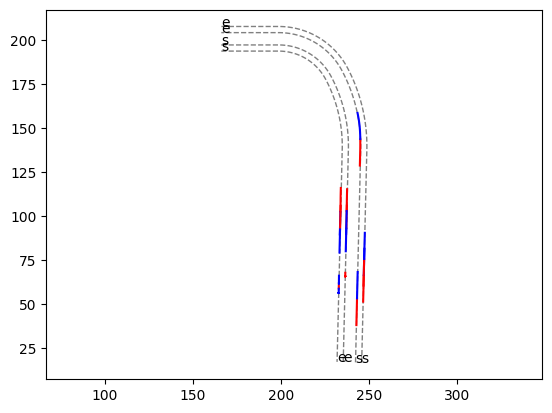

In [282]:
#plot scene before transformation
for road_id in road_ids:
    road = roads[road_id]
    ctr_line = torch.from_numpy(np.stack(((roads[road_id].l_bound[:,0]+roads[road_id].r_bound[:,0])/2, 
                    (roads[road_id].l_bound[:,1]+roads[road_id].r_bound[:,1])/2),axis=-1))
    visualize_centerline(ctr_line)
for i in range(x_orin.shape[0]):
    plt.plot(x_orin[i][:50,0], x_orin[i][:50,1],'r')
    plt.plot(x_orin[i][50:,0], x_orin[i][50:,1],'b')


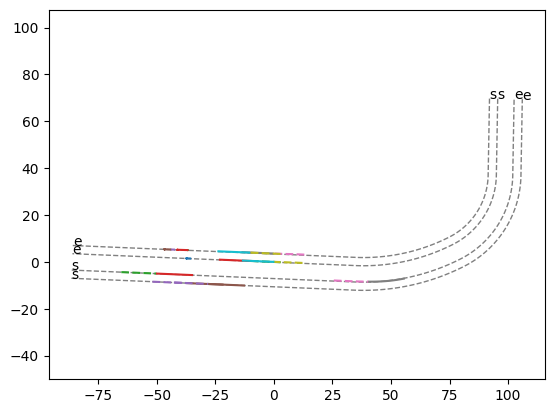

In [304]:
# plot scene after transformation
for i in np.unique(lane_idcs):
    line_ctr = lane_ctrs[lane_idcs == i]
    line_vector = lane_vectors[lane_idcs == i]
    line_str = (2.0 * line_ctr - line_vector) / 2.0
    line_end = (2.0 * line_ctr + line_vector) / 2.0
    line = np.vstack([line_str, line_end[-1,:].reshape(-1, 2)])
    visualize_centerline(line)

for i in range(x.shape[0]):
    plt.plot(positions[i][:50,0], positions[i][:50,1], '--')
    plt.plot(positions[i][50:,0], positions[i][50:,1])

# #plot scene before transformation
# for road_id in road_ids:
#     road = roads[road_id]
#     ctr_line = torch.from_numpy(np.stack(((roads[road_id].l_bound[:,0]+roads[road_id].r_bound[:,0])/2, 
#                     (roads[road_id].l_bound[:,1]+roads[road_id].r_bound[:,1])/2),axis=-1))
#     ctr_line = torch.matmul(rotate_mat, (ctr_line - origin.reshape(-1, 2)).T.float()).T
#     visualize_centerline(ctr_line)
# for i in range(x_orin.shape[0]):
#     x_orin1 = torch.matmul(rotate_mat, (x_orin[i] - origin.reshape(-1, 2)).T).T
#     plt.plot(x_orin1[:50,0], x_orin1[:50,1],'r')
#     plt.plot(x_orin1[50:,0], x_orin1[50:,1],'b')

In [293]:
lanes=dict()
for road_id in road_ids:
    road = roads[road_id]
    ctr_line = torch.from_numpy(np.stack(((roads[road_id].l_bound[:,0]+roads[road_id].r_bound[:,0])/2, 
                    (roads[road_id].l_bound[:,1]+roads[road_id].r_bound[:,1])/2),axis=-1))
    ctr_line = torch.matmul(rotate_mat, (ctr_line - origin.reshape(-1, 2)).T.float()).T

    x, y = ctr_line[:,0], ctr_line[:,1]

    """getting polygons requires original centerline"""
    polygon, _, _ = load_xml.build_polygon_bboxes({road_id: roads[road_id]})
    polygon_x = torch.Tensor([polygon[:,0],polygon[:,0],polygon[:,2],polygon[:,2],polygon[:,0]])
    polygon_y = torch.Tensor([polygon[:,1],polygon[:,3],polygon[:,3],polygon[:,1],polygon[:,1]])
    polygon_reshape = torch.cat([polygon_x,polygon_y],dim=-1) #shape(5,2)

    road.centerline = ctr_line
    road.polygon = torch.matmul(rotate_mat, (polygon_reshape - origin.reshape(-1, 2)).T).T
    lanes[road_id] = road

lane_ids = list(lanes.keys())
lane_ctrs, lane_vectors = [], []
for lane_id in lane_ids:
    lane = lanes[lane_id]
    ctrln = lane.centerline
    num_segs = len(ctrln) - 1

    # lane_ctrs.append(torch.from_numpy(np.asarray((ctrln[:-1]+ctrln[1:])/2.0, np.float32)))#lane center point
    # lane_vectors.append(torch.from_numpy(np.asarray(ctrln[1:]-ctrln[:-1], np.float32))) #length between waypoints
    lane_ctrs.append((ctrln[:-1]+ctrln[1:])/2.0)#lane center point
    lane_vectors.append(ctrln[1:]-ctrln[:-1])#length between waypoints


lane_idcs = []
count = 0
for i, ctr in enumerate(lane_ctrs):
    lane_idcs.append(i*torch.ones(len(ctr)))
    count += len(ctr)

lane_idcs = torch.cat(lane_idcs, dim=0)
lane_ctrs = torch.cat(lane_ctrs, dim=0)
lane_vectors = torch.cat(lane_vectors, dim=0)



In [265]:
def visualize_centerline(centerline) -> None:
    """Visualize the computed centerline.
    Args:
        centerline: Sequence of coordinates forming the centerline
    """
    line_coords = list(zip(*centerline))
    lineX = line_coords[0]
    lineY = line_coords[1]
    plt.plot(lineX, lineY, "--", color="grey", alpha=1, linewidth=1, zorder=0)
    plt.text(lineX[0], lineY[0], "s")
    plt.text(lineX[-1], lineY[-1], "e")
    plt.axis("equal")

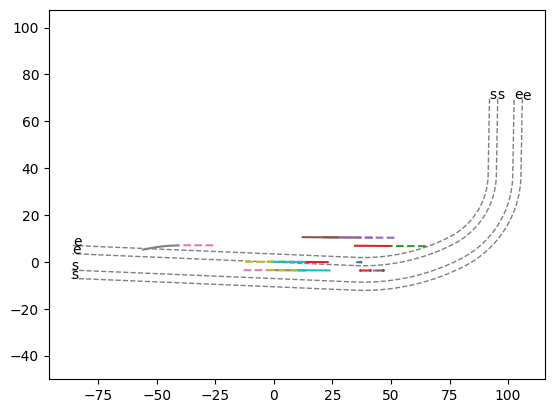

In [298]:
for i in np.unique(lane_idcs):
    line_ctr = lane_ctrs[lane_idcs == i]
    line_vector = lane_vectors[lane_idcs == i]
    line_str = (2.0 * line_ctr - line_vector) / 2.0
    line_end = (2.0 * line_ctr + line_vector) / 2.0
    line = np.vstack([line_str, line_end[-1,:].reshape(-1, 2)])
    visualize_centerline(line)

for i in range(positions.shape[0]):
    plt.plot(positions[i][:50,0], positions[i][:50,1], '--')
    plt.plot(positions[i][50:,0], positions[i][50:,1])

In [216]:
def visualize_data(self, data):
    """
    visualize the extracted data, and exam the data
    """
    fig = plt.figure(0, figsize=(8, 7))
    fig.clear()

    # visualize the centerlines
    lines_ctrs = data.lane_ctrs
    lines_vectors = data.lane_vectors
    lane_idcs = data.lane_idcs
    for i in np.unique(lane_idcs):
        line_ctr = lines_ctrs[lane_idcs == i]
        line_vector = lines_vectors[lane_idcs == i]
        line_str = (2.0 * line_ctr - line_vector) / 2.0
        line_end = (2.0 * line_ctr + line_vector) / 2.0
        line = np.vstack([line_str, line_end[-1,:].reshape(-1, 2)])
        self.visualize_centerline(line)

    # visualize the trajectory
    # hist = data.x #[N,50,2]
    # fut = data.y #[N,50,2]
    hist = data.positions[:,:50,:]
    fut = data.positions[:,50:,:]
    obj_type = data.obj_type_02

    for i in range(hist.shape[0]):
    # for i, [traj, has_obs, pred, has_pred] in enumerate(zip(trajs, has_obss, preds, has_preds)):
        self.plot_traj(hist[i], fut[i], obj_type[i], i)

    plt.xlabel("Map X")
    plt.ylabel("Map Y")
    # plt.axis("off")
    # plt.show()
    plt.savefig('scene_process.png', dpi=fig.dpi)
    plt.show(block=False)
    plt.pause(5)

def visualize_centerline(self, centerline) -> None:
    """Visualize the computed centerline.
    Args:
        centerline: Sequence of coordinates forming the centerline
    """
    line_coords = list(zip(*centerline))
    lineX = line_coords[0]
    lineY = line_coords[1]
    plt.plot(lineX, lineY, "--", color="grey", alpha=1, linewidth=1, zorder=0)
    plt.text(lineX[0], lineY[0], "s")
    plt.text(lineX[-1], lineY[-1], "e")
    plt.axis("equal")

def plot_traj(self, obs, pred, obj_type, traj_id):
    
    traj_na = "t{}".format(traj_id) if traj_id else "traj"
    obj_type = obj_type.upper()

    plt.plot(obs[:, 0], obs[:, 1], "--", color=self.COLOR_DICT[obj_type], alpha=1, linewidth=1, zorder=15)
    plt.plot(pred[:, 0], pred[:, 1], color=self.COLOR_DICT[obj_type], alpha=1, linewidth=1, zorder=20)

    # plt.text(obs[0, 0], obs[0, 1], "{}_s".format(traj_na))

    # if len(pred) == 0:
    #     plt.text(obs[-1, 0], obs[-1, 1], "{}_e".format(traj_na))
    # else:
    #     plt.text(pred[-1, 0], pred[-1, 1], "{}_e".format(traj_na))

In [3]:
import os
import sys
sys.path.append('/Users/xichen/Documents/paper2-traj-pred/carla-data')
import VectorNet.utils.carla_process_cav as preprocess

In [4]:
test = preprocess.scene_process()

In [10]:
data =  test.process(df,237)

In [11]:
data

CarlaData(x=[13, 50, 2], edge_index=[2, 156], y=[13, 50, 2], positions=[13, 100, 2], seq_id=237, num_nodes=13, padding_mask=[13, 100], bos_mask=[13, 50], rotate_angles=[13], lane_vectors=[364, 2], lane_ctrs=[364, 2], lane_idcs=[364], theta=-1.5884658098220825, rotate_mat=[2, 2], obj_type_02=[13], obj_type_04=[13], obj_type_06=[13], obj_type_08=[13], in_av_range=[13], origin=[1, 2])

In [12]:
data.x.shape

torch.Size([13, 50, 2])

In [13]:
data.obj_type_04.shape

torch.Size([13])

In [5]:
# folder path
dir_path = "../../scene_mining_intermediate/small_data/"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 57


In [6]:
#split into Train, Val, Test
train_idx = int(count*0.8)
val_idx = int(count*0.9)

In [19]:
val_idx

51

In [7]:
for i in range(train_idx):
    test.__getitem__(i,"train")
for i in range(train_idx, val_idx):
    test.__getitem__(i, "val")
for i in range(val_idx, count):
    test.__getitem__(i, "test")

/Users/xichen/Documents/paper2-traj-pred/carla-data/VectorNet/utils/carla_process_cav.py:270: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  polygon_x = torch.Tensor([polygon[:,0],polygon[:,0],polygon[:,2],polygon[:,2],polygon[:,0]])


In [24]:
data_root = "../../scene_mining_cav/"
dataset_input_path = os.path.join(data_root)
train_dataset = preprocess.scene_processed_dataset(dataset_input_path, 'train', map_radius=75)
val_dataset = preprocess.scene_processed_dataset(dataset_input_path, 'val', map_radius=75)

In [25]:
train_dataset

scene_processed_dataset(45)

In [26]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset)


In [ ]:
train_loader.__iter__().next()

In [34]:
train_dataset[0]

CarlaData(x=[24, 50, 2], y=[24, 50, 2], positions=[24, 100, 2], seq_id=21, num_nodes=24, padding_mask=[24, 100], bos_mask=[24, 50], rotate_angles=[24], lane_vectors=[812, 2], lane_ctrs=[812, 2], lane_idcs=[812], theta=-1.5720062255859375, rotate_mat=[2, 2], obj_type_02=[24], obj_type_04=[24], obj_type_06=[24], obj_type_08=[24], in_av_range=[24], origin=[1, 2])